In [10]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

from augment import CutMix
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [11]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Augmentations

In [12]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './images'
full_dataset = datasets.ImageFolder(data_dir) 

indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

# the value for the split are found manually to have 150 pictures of each class in training
split = int(0.74 * len(full_dataset))
train_indices, val_indices = indices[:split-1], indices[split-1:]

train_dataset = Subset(datasets.ImageFolder(data_dir, transform=data_transforms["train"]), train_indices)
val_dataset   = Subset(datasets.ImageFolder(data_dir, transform=data_transforms["val"]), val_indices)


N_train = len(train_dataset)
N_val = len(val_dataset)

print(f"Training set size: {N_train} images")
print(f"Validation set size: {N_val} images")


cutmix_transform = CutMix()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=cutmix_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

Training set size: 300 images
Validation set size: 107 images


/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


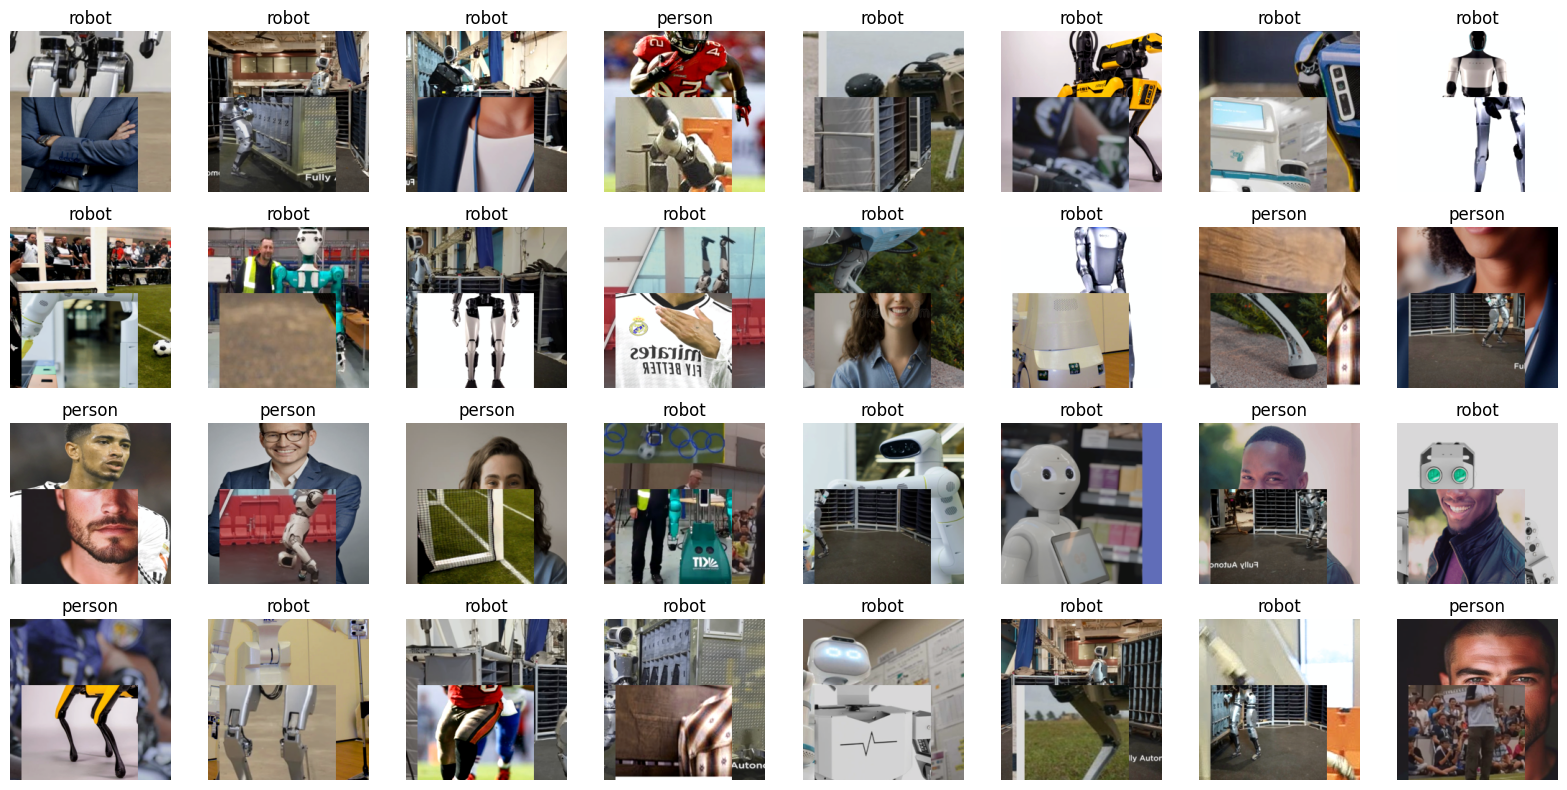

In [13]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2, 4*2))
    for i in range(32):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()
    
class_names = class_names = train_dataset.dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[1-int(x <= 0.5)] for x in classes]        
show_grid(inputs, titles)

## Training

In [14]:
set_random_seed()

In [15]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256, 1)
)
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/3)

In [17]:
TBOARD_LOGS = os.path.join(BASE_LOG_DIR, "ResNet_tuned")
os.makedirs(TBOARD_LOGS, exist_ok=True)

shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [18]:
train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=resnet_model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=val_loader, num_epochs=20, device=device, tboard=writer
    )

  0%|                                                                                                                       | 0/20 [00:00<?, ?it/s]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  5%|█████▌                                                                                                         | 1/20 [00:03<01:04,  3.42s/it]

Epoch 1/20
    Train loss: 0.59949
    Valid loss: 0.74098
    Accuracy: 38.31775700934579%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|███████████                                                                                                    | 2/20 [00:06<00:59,  3.29s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 15%|████████████████▋                       

Epoch 6/20
    Train loss: 0.3441
    Valid loss: 0.10158
    Accuracy: 97.19626168224299%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 35%|██████████████████████████████████████▊                                                                        | 7/20 [00:22<00:41,  3.18s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 40%|████████████████████████████████████████

Epoch 11/20
    Train loss: 0.35076
    Valid loss: 0.09044
    Accuracy: 97.19626168224299%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 60%|██████████████████████████████████████████████████████████████████                                            | 12/20 [00:39<00:26,  3.35s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 65%|████████████████████████████████████████

Epoch 16/20
    Train loss: 0.30343
    Valid loss: 0.08558
    Accuracy: 97.19626168224299%




/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 85%|█████████████████████████████████████████████████████████████████████████████████████████████▌                | 17/20 [00:55<00:09,  3.27s/it]/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 90%|████████████████████████████████████████

Epoch 20/20
    Train loss: 0.34354
    Valid loss: 0.08411
    Accuracy: 97.19626168224299%


Training completed
